# Группа: DST-48
**Sergey Pinaev - binom1982@gmail.com**
# Проект №7: Ford vs Ferrari (классификация автомобилей)
Ссылка на соревнование: [[SF-DST] Car classification](https://www.kaggle.com/c/sf-dl-car-classification)
<p align="center" width="100%">
<img src="https://i.ytimg.com/vi/vCL4Molp4pw/sddefault.jpg" width="600"/>
</p>
<hr>

[Лучшие модели классификации](https://paperswithcode.com/task/image-classification)

<!-- Также можете посмотреть [бейзлайн от Алекса Лекова](https://www.kaggle.com/itslek/baseline-keras-xception-car-class-v2-0)

[Здесь](https://github.com/sedol1339/skillfactory-project-7) вы можете посмотреть результаты проверки проекта у других студентов. -->

# Libraries

In [1]:
# Подключим видеокарту
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-f6280479-d16b-33b8-dd70-6511eca96aa8)


In [2]:
# Загружаем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle
import zipfile
import csv
import sys
import os
import gc


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
# import tensorflow.keras.models as Model
from tensorflow.keras import Model
from tensorflow.keras import Sequential
import tensorflow.keras.layers as Layer

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
plt.style.use('fivethirtyeight')
# plt.rcParams['figure.constrained_layout.use'] = True
# print(os.listdir("./"))

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

# Чтобы вычисления проходили на GPU необходимо чтобы tensorflow определил GPU.
# Как это сделать практически без боли написано здесь https://artificialintelligence.so/forums/discussion/how-to-install-tensorflow/
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()

Python       : 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.5.0
Keras        : 2.5.0
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functions

In [3]:
def plot_history(history):
    '''Отображает графики точности и фунции ошибки'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig,ax = plt.subplots(2,1,figsize=(10,10))
    ax1,ax2 = ax.flatten()
    # ax1.set_xlim(0, max(epochs))
    # ax1.set_ylim(0, max(max(acc),max(val_acc)))
    ax1.set_title('Training and validation accuracy');
    sns.lineplot(y=acc, x=epochs , ax=ax1,palette='gist_rainbow' , label='Training acc')
    sns.lineplot(y=val_acc, x=epochs , ax=ax1,palette='viridis' , label='Validation acc')
    ax2.set_title('Training and validation loss');
    sns.lineplot(y=loss, x=epochs , ax=ax2, palette='gist_rainbow' , label='Training loss')
    sns.lineplot(y=val_loss, x=epochs , ax=ax2, palette='viridis' , label='Validation loss')
    # plt.tight_layout()


def fit_model(lr, defrost):
        '''Функция для тренировки обучения'''
        '''defrost - сколько слоев нужно разморозить [0:1]'''
        base_model.trainable = True
        #EPOCHS = 10

        base_model.trainable = True
        # Fine-tune слой с размороженными слоями
        fine_tune_at = int(len(base_model.layers) * (1 - defrost))

        # Замораживаем слои до `fine_tune_at` слоя
        for layer in base_model.layers[:fine_tune_at]:
                layer.trainable =  False

        model.compile(loss="categorical_crossentropy", 
                optimizer=optimizers.Adam(learning_rate=lr), 
                metrics=["accuracy"])
        
        # model.summary()

        with tf.device('/gpu:0'): # Этот параметр вроде не обязателен, тк если tensorflow определит GPU, 
        # то вычисления будут выполняться на нем.
                history = model.fit(
                        train_datagen,
                        steps_per_epoch = train_datagen.samples//train_datagen.batch_size,
                        validation_data = test_datagen, 
                        validation_steps = test_datagen.samples//test_datagen.batch_size,
                        epochs = EPOCHS,
                        callbacks = callbacks_list
                )
        
        # model.load_weights('model/best_model.hdf5')
        
        scores = model.evaluate(test_datagen, verbose=1)
        print("Accuracy: %.2f%%" % (scores[1]*100))

        plot_history(history)


def create_submission(predictions, file_name = 'submission.csv'):
    '''Создаем submission'''
    predictions = np.argmax(predictions, axis=-1) #multiple categories
    label_map = (train_datagen.class_indices)
    label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
    predictions = [label_map[k] for k in predictions]

    filenames_with_dir=test_sub_generator.filenames
    submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                            columns=['Id', 'Category'])
    submission.to_csv(file_name, index=False)


# https://www.kaggle.com/sudhirnl7/logistic-regression-with-stratifiedkfold

# Setup

In [4]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
RANDOM_SEED          = 42

EPOCHS               = 8  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = 'G:/Datasets/sf-dl-car-classification/'
# PATH = "/working/" # рабочая директория

# подготавливаем данные
sample_submission_path = DATA_PATH + 'sample-submission.csv'
train_path = DATA_PATH + 'train/'
sub_path = DATA_PATH + 'test_upload/'

# имена классов
class_names = [
  'Приора', #0
  'Ford Focus', #1
  'Самара', #2
  'ВАЗ-2110', #3
  'Жигули', #4
  'Нива', #5
  'Калина', #6
  'ВАЗ-2109', #7
  'Volkswagen Passat', #8
  'ВАЗ-21099' #9
]

# EDA

In [5]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
train_df.head()
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

In [6]:
# Пропусков нет
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


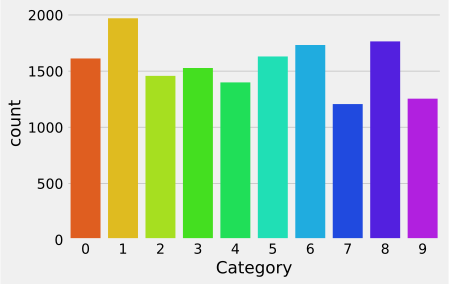

In [7]:
# Данные распределены равномерно
sns.countplot(data=train_df,x='Category',palette='gist_rainbow'); # viridis

Пример картинок


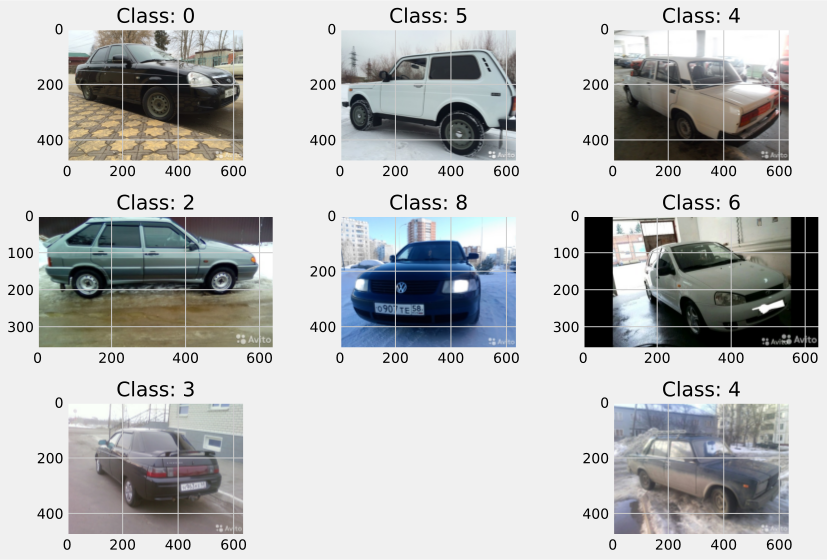

In [8]:
# Посмотрим на примеры картинок и их размеры, чтобы понимать, как их лучше обрабатывать и сжимать.
print('Пример картинок')
plt.figure(figsize=(12,8))
 
random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im) 
    plt.title('Class: '+str(random_image_cat[index]))
    # plt.axis('off')
    plt.tight_layout()
    
# plt.show()

In [9]:
#delete df no longer needed
# del train_df
#collect residual garbage
# gc.collect()

# Augmentation data

In [10]:
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации
# !pip install git+https://github.com/mjkvaak/ImageDataAugmentor
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [11]:
# Настройки аугментации изображений
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

C:\Users\binom\anaconda3\envs\tensorflow_25\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# Generate data

In [12]:
# Обратите внимание, что строка `#rescale=1/255` закомментирована. Это означает, что генераторы выдают изображения с яркостью цветовых каналов пикселя от 0 до 255. Дальнейшие действия зависят от того, какую нейронную сеть вы будете использовать, например:
# *    EfficientNetB0, которая используется в бейзлайне, не требует нормализации (нормализация встроена в саму модель)
# *    Xception требует нормализацию, поэтому нужно либо раскомментировать строку `#rescale=1/255`, либо встроить нормализацию в модель, добавив например такой слой: `Lamba(lambda x: x/255)`
# my_xception = Sequential([
#   Lambda(lambda x: x/255), #не забудем нормализацию для Xception (в EfficientNetB0 она уже встроена)
#   Xception(input_shape=(*image_size, 3), include_top=False),
#   GlobalMaxPool2D()
# ])
# my_effi


# Добавляем аугментацию
train_gen = ImageDataAugmentor(#rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )
# Инициализируем генератор для обучения 
train_datagen = train_gen.flow_from_directory(DATA_PATH+'train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
# Инициализируем генератор для валидации
test_datagen = train_gen.flow_from_directory(DATA_PATH+'train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )



Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


Примеры для обучения


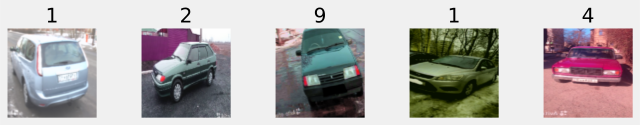

Примеры для валидации


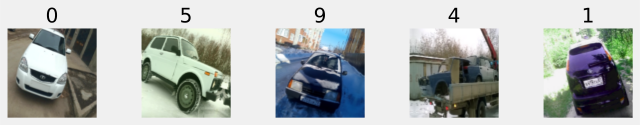

In [13]:
plt.rcParams['figure.constrained_layout.use'] = False
print('Примеры для обучения')
train_datagen.show_data(rows=1, cols=5)
print('Примеры для валидации')
test_datagen.show_data(rows=1, cols=5)
plt.rcParams['figure.constrained_layout.use'] = True

In [14]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB5, EfficientNetB6, EfficientNetB7

# pip install -U keras-cv-attention-models
# https://pythonawesome.com/keras-attention-models-including-botnet-coat-coatnet-cmt-cotnet-halonet-resnest-resnext/#coatnet
# Model	Params	Image resolution	Top1 Acc
# CoAtNet-0	25M	224	81.6
# CoAtNet-1	42M	224	83.3
# CoAtNet-2	75M	224	84.1
# CoAtNet-2, ImageNet-21k pretrain	75M	224	87.1
# CoAtNet-3	168M	224	84.5
# CoAtNet-3, ImageNet-21k pretrain	168M	224	87.6
# CoAtNet-3, ImageNet-21k pretrain	168M	512	87.9
# CoAtNet-4, ImageNet-21k pretrain	275M	512	88.1
# CoAtNet-4, ImageNet-21K + PT-RA-E150	275M	512	88.56
from keras_cv_attention_models import coatnet

# # No pretraind available.
# mm = coatnet.CoAtNet0()
# mm.summary()

In [15]:
# Предоубченные модели

# base_model = Xception(weights='imagenet', 
#                      include_top=False, 
#                      input_shape = input_shape)

# base_model = InceptionV3(weights='imagenet', 
#                         include_top=False, 
#                         input_shape = input_shape)

# base_model = coatnet.CoAtNet3(input_shape = input_shape, num_classes=10)                       
# # Убираем голову модели
# base_model = Model(inputs=base_model.inputs, outputs=base_model.get_layer("avg_pool").output)

# base_model = EfficientNetB6(weights='imagenet', 
#                                 include_top=False, 
#                                 input_shape = input_shape)

# base_model = EfficientNetB7(weights='imagenet', 
#                                 include_top=False, 
#                                 input_shape = input_shape)

In [16]:
# base_model.compile(loss="categorical_crossentropy", 
#                 optimizer=optimizers.Adam(learning_rate=LR), 
#                 metrics=["accuracy"])
        
# scores = base_model.evaluate(test_datagen, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [17]:
# # freeze the pre-trained model weights, train only the top layers
base_model.trainable = False
# base_model.include_top = False, 

In [26]:
model= Sequential() # Model.Sequential()
model.add(base_model)
model.add(Layer.GlobalAveragePooling2D())
model.add(Layer.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)))
model.add(Layer.BatchNormalization())
model.add(Layer.Dropout(0.25))
model.add(Layer.Dense(CLASS_NUM, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1536)              161130204 
_________________________________________________________________
dense (Dense)                (None, 10)                15370     
Total params: 161,145,574
Trainable params: 15,370
Non-trainable params: 161,130,204
_________________________________________________________________


In [20]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x0000017EA97DD3D0> False
<tensorflow.python.keras.layers.core.Dense object at 0x0000017EC7681DC0> True


# Fit
## Step 1
### Заморозим все веса предварительно обученной модели

In [21]:
# Добавим ModelCheckpoint. 
# Эта функция позволяет сохранять прогресс обучения модели, 
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('models/best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
# останавливает обучение, когда точность на валидации не растёт в течение patience эпох
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [ ]:
fit_model(lr=LR, defrost=0)

## Step 2
### Разморозим 50% весов предварительно обученной модели

In [ ]:
model.load_weights('models/best_model.hdf5')
LR=0.0001
fit_model(lr=LR, defrost=0.5)

## Step 3
### Разморозим 75% весов предварительно обученной модели

In [ ]:
model.load_weights('models/best_model.hdf5')
LR=0.00001 # Уменьшаем шаг обучения
fit_model(lr=LR, defrost=0.75)

## Step 4
### Разморозим 100% весов предварительно обученной модели

Epoch 1/8
1654/1654 [==============================] - 925s 537ms/step - loss: 0.1122 - accuracy: 0.9658 - val_loss: 0.1845 - val_accuracy: 0.9442

Epoch 00001: saving model to models\best_model.hdf5


C:\Users\binom\anaconda3\envs\tensorflow_25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/8
1654/1654 [==============================] - 853s 516ms/step - loss: 0.1077 - accuracy: 0.9679 - val_loss: 0.1818 - val_accuracy: 0.9502

Epoch 00002: saving model to models\best_model.hdf5
Epoch 3/8
1654/1654 [==============================] - 864s 522ms/step - loss: 0.1036 - accuracy: 0.9681 - val_loss: 0.1789 - val_accuracy: 0.9480

Epoch 00003: saving model to models\best_model.hdf5
Epoch 4/8
1654/1654 [==============================] - 878s 531ms/step - loss: 0.1002 - accuracy: 0.9689 - val_loss: 0.1786 - val_accuracy: 0.9515

Epoch 00004: saving model to models\best_model.hdf5
Epoch 5/8
1654/1654 [==============================] - 862s 521ms/step - loss: 0.1008 - accuracy: 0.9705 - val_loss: 0.1557 - val_accuracy: 0.9536

Epoch 00005: saving model to models\best_model.hdf5
Epoch 6/8
1654/1654 [==============================] - 846s 511ms/step - loss: 0.0967 - accuracy: 0.9699 - val_loss: 0.1767 - val_accuracy: 0.9416

Epoch 00006: saving model to models\best_model.hdf5


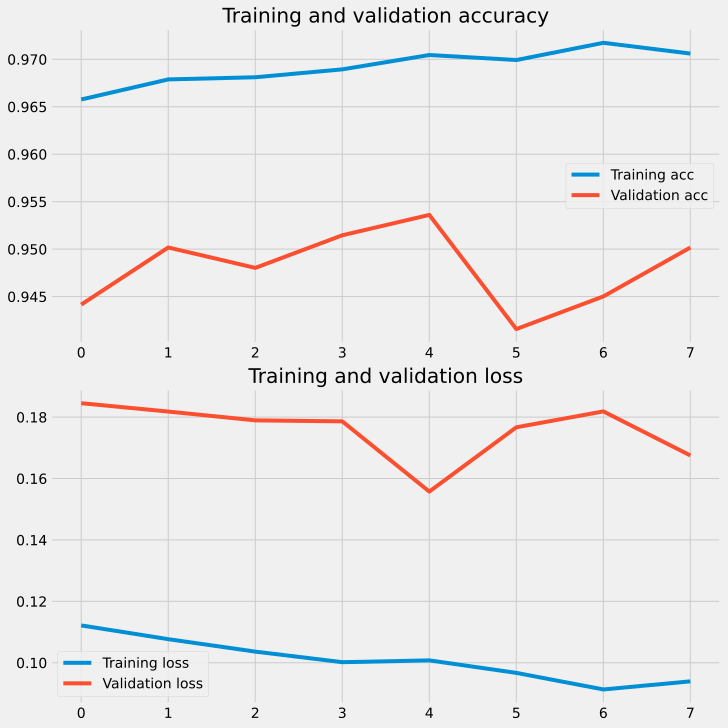

In [ ]:
model.load_weights('models/best_model.hdf5')
LR=0.000001 # Уменьшаем шаг обучения
fit_model(lr=LR, defrost=1)

##  Prediction
### Предсказание после fine-tuning

In [ ]:
test_gen = ImageDataAugmentor(rescale=1./255)
test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                            directory=DATA_PATH+'/test_upload/',
                                            x_col="Id",
                                            y_col=None,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            batch_size=BATCH_SIZE)

In [ ]:
# model.load_weights('models/best_model.hdf5')
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 

create_submission(predictions, 'submission EfficientNetB7 (fine-tuning).csv')

## Step 5. 
### Для последней обученной модели увелчим размер изображений до 512

In [ ]:
EPOCHS               = 6 # эпох на обучение (было 8)
BATCH_SIZE           = 1 # 4(был 8)
LR                   = 1e-5 # (был 1e-3)
IMG_SIZE             = 512 # (было 224)
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
AUGMENTATIONS = A.Compose([
    #A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.HorizontalFlip(p=0.5),
    #A.HueSaturationValue(p=0.5)
])

In [ ]:
train_gen = ImageDataAugmentor(#rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

train_datagen = train_gen.flow_from_directory(DATA_PATH+'/train', 
                                            class_mode='categorical', 
                                            batch_size=BATCH_SIZE, 
                                            target_size=(IMG_SIZE, IMG_SIZE),
                                            shuffle=True,
                                            subset='training'
                                           )
test_datagen = train_gen.flow_from_directory(DATA_PATH+'/train', 
                                             class_mode='categorical', 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             shuffle=True,
                                             subset='validation'
                                            )


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
# Пересоздадим сеть для нового размера изображений

# base_model = Xception(weights='imagenet', 
#                            include_top=False, 
#                            input_shape = input_shape)

# base_model = InceptionV3(weights='imagenet', 
#                            include_top=False, 
#                            input_shape = input_shape)


# base_model = efn.EfficientNetB5(weights='imagenet', 
#                             include_top=False, 
#                             input_shape = input_shape)

base_model = EfficientNetB7(weights='imagenet', 
                             include_top=False, 
                             input_shape = input_shape)

Epoch 1/6
13232/13232 [==============================] - 5589s 420ms/step - loss: 2.3975 - accuracy: 0.1108 - val_loss: 5.7914 - val_accuracy: 0.7952

Epoch 00001: saving model to models\best_model.hdf5


C:\Users\binom\anaconda3\envs\tensorflow_25\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/6
13232/13232 [==============================] - 5451s 412ms/step - loss: 2.3180 - accuracy: 0.1136 - val_loss: 5.5765 - val_accuracy: 0.7905

Epoch 00002: saving model to models\best_model.hdf5
Epoch 3/6
13232/13232 [==============================] - 5443s 411ms/step - loss: 2.2983 - accuracy: 0.1196 - val_loss: 5.9739 - val_accuracy: 0.7694

Epoch 00003: saving model to models\best_model.hdf5
Epoch 4/6
13232/13232 [==============================] - 5453s 412ms/step - loss: 2.2937 - accuracy: 0.1245 - val_loss: 5.6928 - val_accuracy: 0.7750

Epoch 00004: saving model to models\best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
Epoch 5/6
13232/13232 [==============================] - 5426s 410ms/step - loss: 2.2936 - accuracy: 0.1239 - val_loss: 5.6723 - val_accuracy: 0.7677

Epoch 00005: saving model to models\best_model.hdf5
2329/2329 [==============================] - 208s 89ms/step - loss: 5.7782 - accuracy: 0.7896
Accuracy: 78.

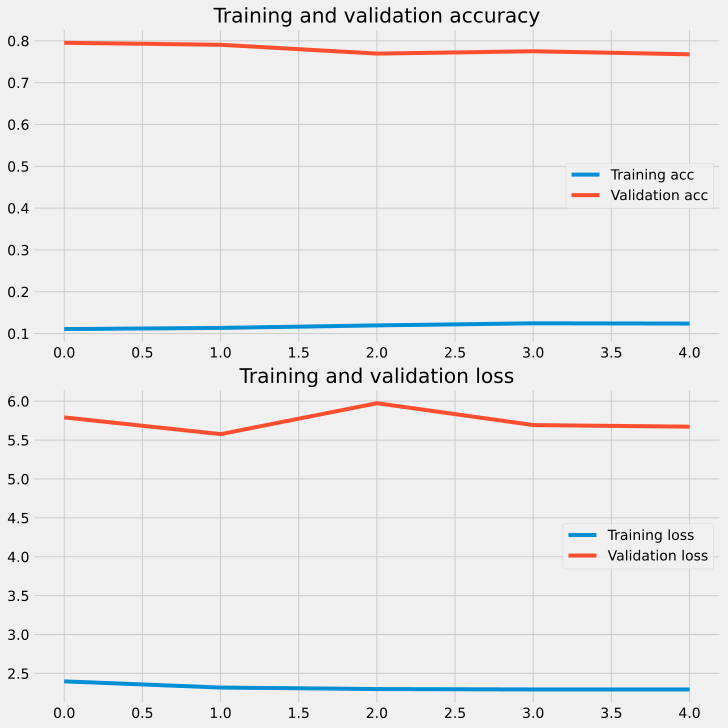

In [ ]:
model.load_weights('models/best_model.hdf5')
fit_model(lr=LR, defrost=1)

In [ ]:
model.load_weights('models/best_model.hdf5')
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, 
                                      steps=len(test_sub_generator), 
                                      verbose=1) 
create_submission(predictions, 'submission InceptionV3 image_size_512 (fine-tuning).csv')

## Test Time Augmentation (TTA)
### Сделаем несколько прогнозов одной картинки по-разному. Окончательный прогноз получается путем усреднения нескольких прогнозов.

In [20]:
#model.save('model.h5') #сохранение
# model = keras.models.load_model('models/#EfficientNetB7_defrost_100%_best_model.hdf5') #загрузка

In [22]:
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [23]:
test_gen = ImageDataAugmentor(#rescale=1./255,
                        augment=AUGMENTATIONS, 
                        seed=RANDOM_SEED,
                        validation_split=VAL_SPLIT
                       )

test_sub_generator = test_gen.flow_from_dataframe(dataframe=sample_submission,
                                      directory=DATA_PATH+'test_upload',
                                      x_col="Id",
                                      y_col=None,
                                      target_size=(IMG_SIZE, IMG_SIZE),
                                      batch_size=BATCH_SIZE,
                                      class_mode=None,
                                      shuffle=False)

Found 6675 validated image filenames.


In [24]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

835/835 [==============================] - 95s 113ms/step


In [25]:
scores = model.evaluate(test_datagen, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 40s 117ms/step - loss: 0.1636 - accuracy: 0.9523
Accuracy: 95.23%


In [26]:
create_submission(pred, 'submission EfficientNetB7 TTA.csv')

# Conclusion

## Эффективность моделей
         
**Xception**: Fine-tuning         
Разморожено:
* 0% [loss: 1.1951 - accuracy: 0.5829 - val_loss: 1.0627 - val_accuracy: 0.6336]
* 50% [loss: 0.2002 - accuracy: 0.9324 - val_loss: 0.2634 - val_accuracy: 0.9240]
* 75% [loss: 0.0885 - accuracy: 0.9717 - val_loss: 0.2199 - val_accuracy: 0.9373]
* 100% [loss: 0.0892 - accuracy: 0.9691 - val_loss: 0.2133 - val_accuracy: 0.9394]
 
Размер изображения 512 [loss: 0.1179 - accuracy: 0.9646 - val_loss: 0.1095 - val_accuracy: 0.9678] заняло 100min
> Kaggle 66 Sergey Pinaev 0.96913

TTA Accuracy: **97.04%**
> Kaggle 49 Sergey Pinaev **0.97228**

**InceptionV3**: Fine-tuning         
Разморожено:
* 0% [loss: 1.2316 - accuracy: 0.5698 - val_loss: 1.0456 - val_accuracy: 0.6349]
* 50% [loss: 0.2570 - accuracy: 0.9153 - val_loss: 0.2466 - val_accuracy: 0.9192]
* 100% [loss: 0.2401 - accuracy: 0.9189 - val_loss: 0.2346 - val_accuracy: 0.9210]

Размер изображения 512 [loss: 0.1923 - accuracy: 0.9452 - val_loss: 0.1198 - val_accuracy: 0.9648] заняло 53min

TTA Accuracy: **96.31%**

**EfficientNetB6**: Fine-tuning rescale=1./255, - отключил
* 0% [loss: 0.9588 - accuracy: 0.6669 - val_loss: 0.8098 - val_accuracy: 0.7290]
* 50% [loss: 0.1028 - accuracy: 0.9695 - val_loss: 0.1680 - val_accuracy: 0.9497] заняло 58min
* 100% [loss: 0.0939 - accuracy: 0.9706 - val_loss: 0.1675 - val_accuracy: 0.9502] заняло 116min
> Не получилось сделать увеличить изображения, тк размер уже не влезал на GPU.

**CoAtNet3**
*0% [loss: 2.2883 - accuracy: 0.1279 - val_loss: 2.2885 - val_accuracy: 0.1211]
> Решил попробовать обучить топовую сеть, но не получилось добиться чтобы сеть начала обучаться.
<!--
Fine-tuning **EfficientNetB5**       
0% weights defrosting accuracy 73,55%      
50% weights defrosting accuracy 93.69%        
75% weights defrosting accuracy 94.72%        
100% weights defrosting accuracy 95.02%       
image size rising accuracy 97.25%         
TTA accuracy **%**      -->

**Этапы работы над проектом**:    
- transfer learning и fine-tuning (обучение головы -> 50% разморозка весов предобученной модели -> 75% разморозка -> 100% разморозка)
- дополнительные функции callback в Keras        
- настройка LR    
- настройка параметров регуляризации полносвязного слоя нейронной сети
- применен способ заполнения пропусков c помощью ImageDataAugmentor с использованием библиотеки аугментации изображений albumentations
- подобраны переменные (размер картинки, батч, количество эпох)
- добавлена Batch Normalization в архитектуре “головы” модели
- SOTA архитектура сетей - Xception, InceptionV3, EfficientNetB5
- добавлена TTA (Test Time Augmentation)
               
> Хотя работа велась на локальной машине с GPU: GeForce RTX 2070 SUPER, время на обучение модели довольно существенное поэтому, не удалось протестировать следующие техники настройки модели:
- настройка optimizer
- настройка loss
- использование внешних датасетов для дообучения модели

> В итоге лучший результат на Kaggle (сеть Xception) 49 Sergey Pinaev **0.97228**

<!-- # Что дальше?

Предлагаемый план действий:
1.    Разберите код бейзлайна
1.    Создайте копию ноутбука, удалите все лишнее и оставьте только код
1.    Ищите способы улучшить решение и повысить точность

Рекомендации о том, как повысить точность
*   Обучайте дольше и на большем разрешении
*   Пробуйте использовать другие модели и ансамбли
*   Сделайте больше аугментаций, но не чрезмерно (следите за точностью на валидации)
*   Управляйте learning rate
*   Измените соотношение размеров train/val датасетов
*   Используйте TTA (test-time augmentations)
*   Поищите в интернете обученные нейронные сети для работы с автомобилями
*   Скачайте из интернета дополнительные изображения для обучения
*   Смотрите ноутбуки с решениями других Kaggle-соревнований по CV -->